In [47]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [48]:
def read_data(file):
    df = pd.read_excel(file, header=None)
    matrix = []

    # Iterate over rows to process job data
    for job in df.itertuples(index=False):
        # Convert the row into pairs of (machine, time)
        row_data = list(job)
        job_data = {}
        for i in range(0, len(row_data), 2):
            machine = int(row_data[i])
            time = int(row_data[i+1])
            job_data[machine] = time
        matrix.append(job_data)

    result_df = pd.DataFrame(matrix).fillna(0).astype(int)
    return result_df

In [49]:
data = read_data("JSSP-problems/swv12.xlsx")
data

,0,4,1,3,2,7,6,9,5,8
0,92,49,93,48,1,52,57,16,6,6
1,54,82,86,25,69,6,15,5,31,18
2,31,48,26,46,49,82,91,93,47,74
3,34,37,82,25,43,34,11,71,55,77
4,91,22,97,54,49,46,27,2,98,89
5,44,24,3,70,46,22,60,65,94,58
6,99,29,80,53,74,54,72,69,98,60
7,36,7,87,96,57,70,47,26,94,36
8,57,28,59,5,47,35,19,24,44,79
9,96,39,4,60,43,97,89,81,2,91


# CHROMOSOMA

Representat com una llista de tuples, on gada gen es una tupla. La primera posició de la tupla indica el job i la segona posició indica la màquina. 

In [50]:
jobs = data.shape[0]
t_size = jobs // 2
population_size = jobs * 2
params = {"population_size": population_size, 
          "mutation_rate": 0.5, 
          "crossover_rate": 0.5, 
          "max_generations": 25, 
          "tournament_size": t_size}

In [51]:
def generate_inital_population(data, population_size):
    jobs = data.shape[0]
    machines = data.shape[1]
    population = []
    for _ in range(population_size):
        chromosome = []
        for job in range(jobs):
            for machine in range(machines):
                chromosome.append((job, machine))
        random.shuffle(chromosome)
        population.append(chromosome)
    return population


In [52]:
def fitness(chromosome, data):
    job_end_time = [0] * data.shape[0]  # End time of each job
    machine_end_time = [0] * data.shape[1]  # End time of each machine
    
    for task in chromosome:
        job, machine = map(int, task)
        start_time = max(job_end_time[job], machine_end_time[machine]) # Start time of the task
        job_end_time[job] = start_time + data[machine][job] # Update end time of job
        machine_end_time[machine] = start_time + data[machine][job] # Update end time of machine
    
    return max(machine_end_time)  # Makespan

In [53]:
def selection(population, fitness_values, tournament_size): # Tournament selection
    selected = set()
    
    while len(selected) < 2:  # Select 2 parents
        tournament = random.sample(list(enumerate(fitness_values)), tournament_size)
        winner = min(tournament, key=lambda x: x[1])[0] # Select the chromosome with the lowest fitness value
        selected.add(winner)

    selected = list(selected)
    parent1 = population[selected[0]]
    parent2 = population[selected[1]]
    return parent1, parent2

In [54]:
def crossover(parent1, parent2, probability): # Uniform crossover
    size = len(parent1)
    child1, child2 = [], []

    # Uniform crossover
    for i in range(size):
        if random.random() < probability:
            child1.append(parent1[i])
            child2.append(parent2[i])
        else:
            child1.append(parent2[i])
            child2.append(parent1[i])

    # Repair duplicated genes in children
    def repair(child, parent):
        used_genes = set(child)
        missing_genes = [gene for gene in parent if gene not in used_genes]
        for i in range(size):
            if child.count(child[i]) > 1:  # Check if the gene is duplicated
                if missing_genes:
                    child[i] = missing_genes.pop(0)  # Substitute duplicated gene with a missing gene
        return child

    child1 = repair(child1, parent1)
    child2 = repair(child2, parent2)

    return child1, child2

In [55]:
def mutation(chromosome, mutation_probability): 
    size = len(chromosome)
    original_genes = set(chromosome)
    mutated_genes = set()
    new_chromosome = []

    for i in range(size):
        if random.random() < mutation_probability:
            job, machine = chromosome[i]
            mutated_gene = (machine, job)  # Swap job and machine
            mutated_genes.add(mutated_gene)
    
    for gene in mutated_genes:
        new_chromosome.append(gene)
        missing_genes = [gene for gene in original_genes if gene not in mutated_genes]
        new_chromosome.extend(missing_genes)
            
    return chromosome

In [56]:
def elitism(population, fitness_values):
    elite = min(enumerate(fitness_values), key=lambda x: x[1])[0]  # Select the chromosome with the lowest fitness value
    return population[elite]

In [57]:
def plot_evolution(minimum_fitness_per_generation):
    generations = list(range(len(minimum_fitness_per_generation)))
    plt.figure(figsize=(10, 6))
    plt.plot(generations, minimum_fitness_per_generation, marker='o', label='Minimum Makespan')
    plt.title('Evolution of Minimum Makespan Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Minimum Makespan (Fitness)')
    plt.grid()
    plt.legend()
    plt.show()


In [58]:
def gen_algorithm(data, params):
    population_size = params["population_size"]
    mutation_rate = params["mutation_rate"]
    crossover_rate = params["crossover_rate"]
    max_generations = params["max_generations"]
    tournament_size = params["tournament_size"]

    min_makespan_generation = []
    population = generate_inital_population(data, population_size)
    fitness_values = [fitness(chromosome, data) for chromosome in population]
    for generation in range(max_generations):
        new_population = []
        for _ in range(population_size):
            # Selection
            parent1, parent2 = selection(population, fitness_values, tournament_size)
            #print("--------------------[PARENTS]--------------------")
            #print(parent1)
            #print(parent2)
            # Crossover
            child1, child2 = crossover(parent1, parent2, crossover_rate)
            #print("--------------------[CHILDREN]--------------------")
            #print(child1)
            #print(child2)
            # Mutation
            child1 = mutation(child1, mutation_rate)
            child2 = mutation(child2, mutation_rate)
            #print("--------------------[MUTATION]--------------------")
            #print(child1)
            #print(child2)
            # Add children to the new population
            new_population.append(child1)

        new_population.append(elitism(population, fitness_values))
        population = new_population
        fitness_values = [fitness(chromosome, data) for chromosome in population]
        min_makespan = min(fitness_values)
        min_makespan_generation.append(min_makespan)
    
    best_chromosome = min(enumerate(fitness_values), key=lambda x: x[1])[0]
    plot_evolution(min_makespan_generation)
    return population[best_chromosome], fitness_values[best_chromosome]
    

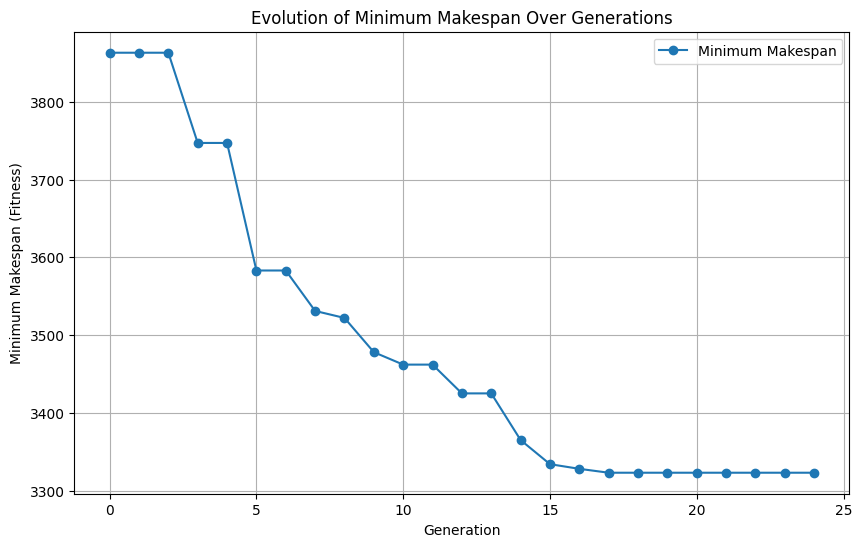

In [59]:
best_solution, fitness = gen_algorithm(data, params)
#print("Best solution:", best_solution)
#print("Fitness:", fitness)

In [73]:
def plot_solution(chromosome, data):
    # Initialize variables
    job_end_time = [0] * data.shape[0]  # End time for each job
    machine_end_time = [0] * data.shape[1]  # End time for each machine
    task_schedule = []  # To store the schedule for plotting
    num_machines = data.shape[1]
    num_jobs = data.shape[0]

    # Process the chromosome
    for job, machine in chromosome:
        start_time = max(job_end_time[job], machine_end_time[machine])
        end_time = start_time + data[machine][job]
        task_schedule.append((job, machine, start_time, end_time))  # Store the task details
        job_end_time[job] = end_time  # Update job end time
        machine_end_time[machine] = end_time  # Update machine end time

    # Plot the Gantt chart
    fig, ax = plt.subplots(figsize=(20, 12))
    machine_colors = plt.cm.tab20.colors

    for job, machine, start_time, end_time in task_schedule:
        ax.barh(machine, end_time - start_time, left=start_time, color=machine_colors[job % 20], edgecolor="black")
        
        if num_jobs <= 20:
            ax.text(
                (start_time + end_time) / 2,
                machine,
                f"J{job}",
                ha="center",
                va="center",
                color="black",
                fontsize=6,
            )
        

    # Customize plot
    ax.set_yticks(range(num_machines))
    ax.set_yticklabels([f"M{m}" for m in range(num_machines)])
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    ax.set_title("Job-Shop Scheduling Solution")
    ax.invert_yaxis()
    plt.grid(axis="x", linestyle="--", alpha=0.7)

    # Legend
    legend_patches = [
        mpatches.Patch(color=machine_colors[job % 20], label=f"Job {job}")
        for job in range(len(data))
    ]
    ax.legend(handles=legend_patches, title="Jobs", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


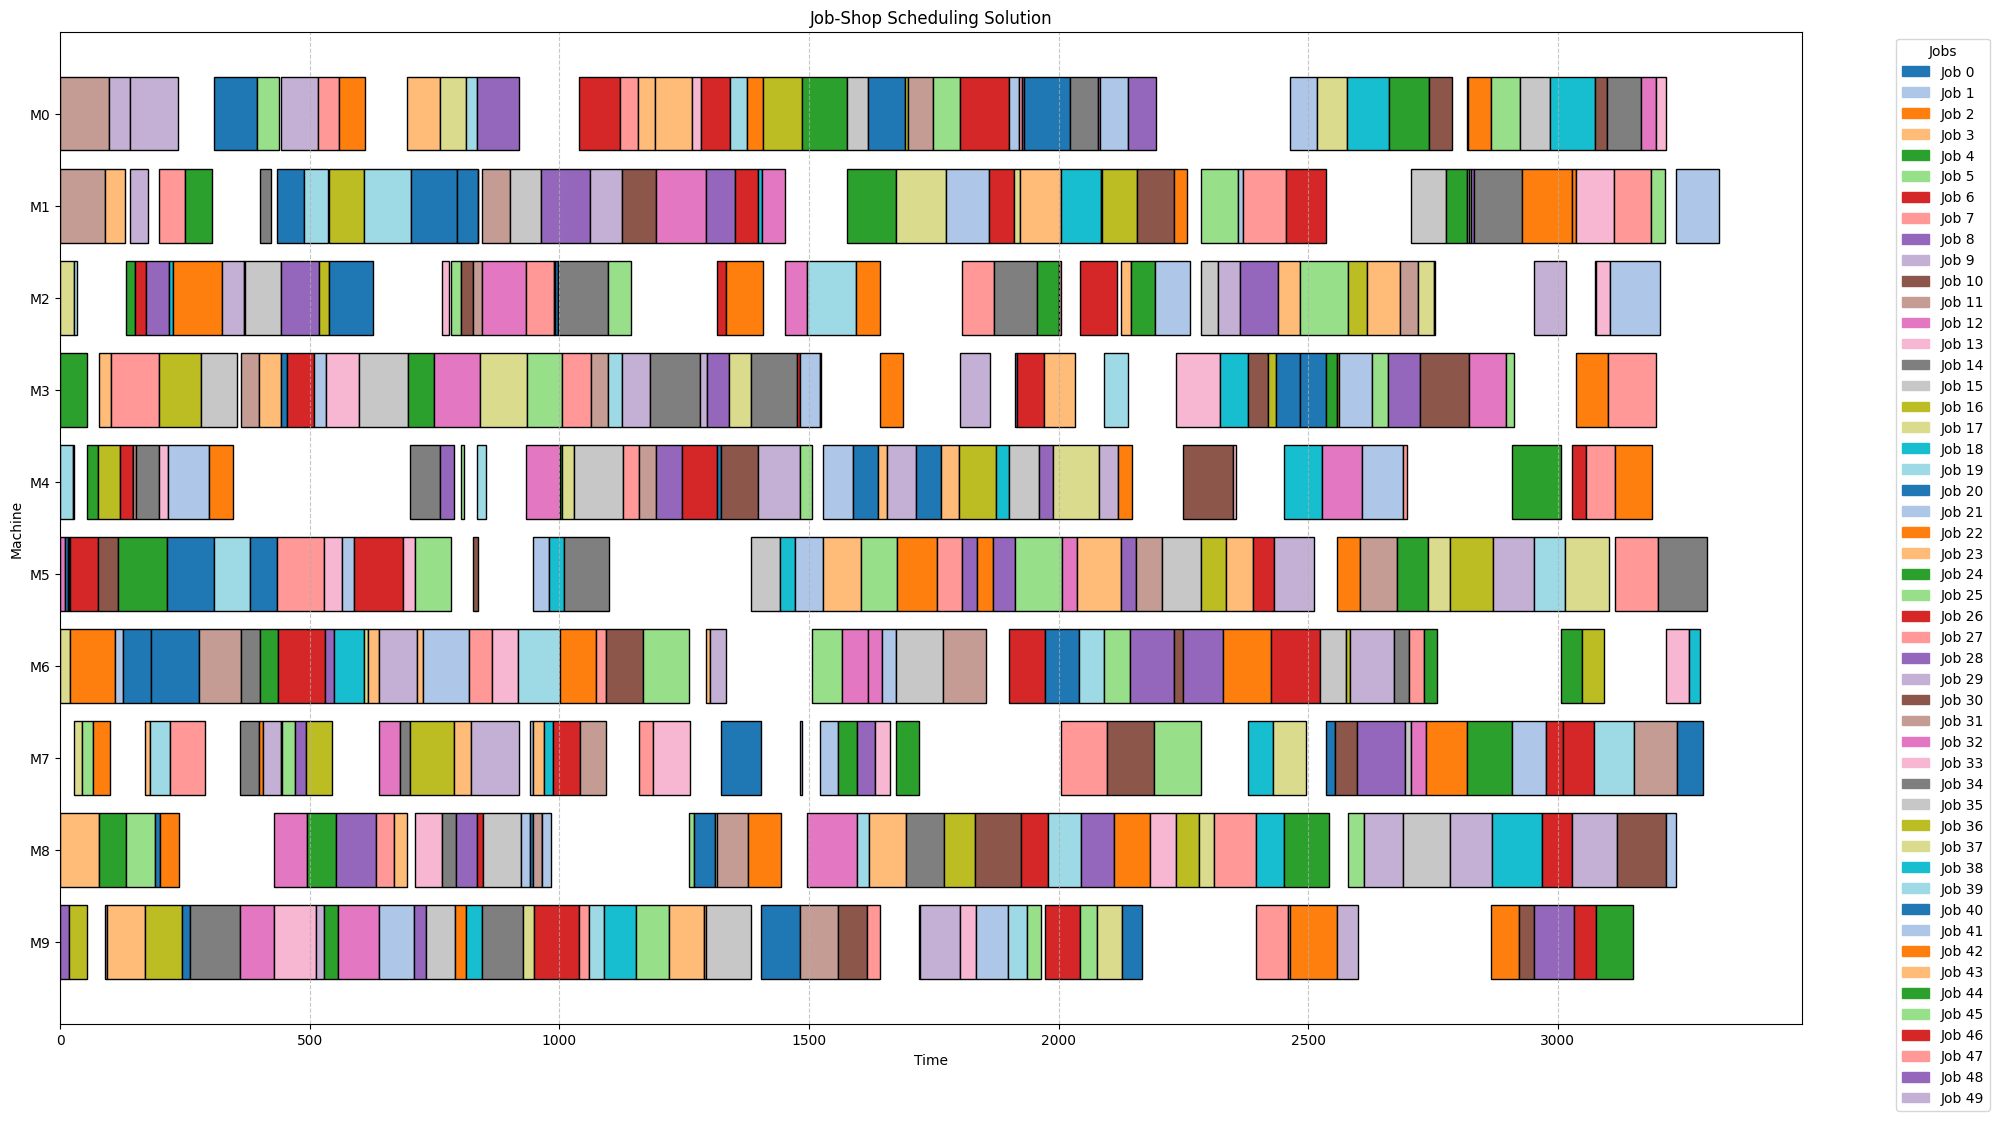

In [74]:
plot_solution(best_solution, data)